<a href="https://colab.research.google.com/github/jhoniers011/TrabajoTAE3/blob/main/TrabajoTae3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lectura de datos

Se cargan las imágenes contenidas en el repositorio de github al entorno de Colab.

In [69]:
#Librerias
import zipfile
import os
import cv2 as cv
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [48]:
%%capture

 #Link del repositorio de github
!wget --no-check-certificate \
    "https://github.com/jhoniers011/TrabajoTAE3/archive/refs/heads/main.zip" \
    -O "/tmp/imagenes.zip"


zip_ref = zipfile.ZipFile('/tmp/imagenes.zip', 'r') #Abre el archivo.zip en modo lectura
zip_ref.extractall('/tmp') #Extrae los archivos en la carpeta /tmp
zip_ref.close()



In [49]:

files = glob.glob('/tmp/TrabajoTAE3-main/Imagenes/**/*.pgm',recursive=True) #Se obtienen todas las url de las imágenes.

Lectura de imagenes

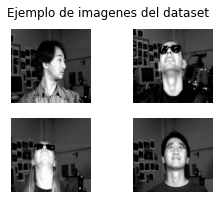

In [50]:

imagenes = [cv.imread(imagen,-1) for imagen in files] #Se cargan las imágenes y se guardan en una lista

#Imprimir ejemplos de imágenes del dataset
#cv2_imshow(imagenes[100])
fig = plt.figure(figsize=(4, 3))
fig.suptitle("Ejemplo de imagenes del dataset")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(imagenes[100],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(imagenes[150],cmap = "gray")
plt.axis('off')
  

fig.add_subplot(rows, columns, 3)
plt.imshow(imagenes[200],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(imagenes[250],cmap = "gray")
plt.axis('off')

plt.show()


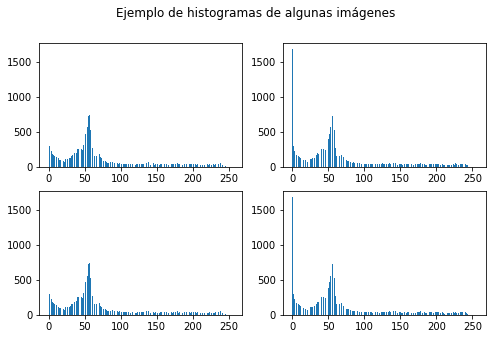

In [51]:
#Mostrando histogramas
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Ejemplo de histogramas de algunas imágenes")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.hist(imagenes[100].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 2)
plt.hist(imagenes[100].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 3)
plt.hist(imagenes[100].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 4)
plt.hist(imagenes[100].ravel(),256,[0,256])

plt.show()

##Segmentación de las imágenes
Se aplica la tecnica de umbral, donde dado un valor limite, los valores menores se cambian a 0 y los mayores a 255, por lo que queda una imagen binarizada. Util para resaltar caracteristicas de las imágenes.
En este caso, como las imágenes se han tomado en ambientes controlados (mismo fondo, misma iluminación, las gafas son las mismas,etc) se aplica la umbralización con el objetivo de eliminar el fondo lo más posible y resaltar las gafas. Se utilizó un valor de 100 como umbral según la forma de los histogramas.

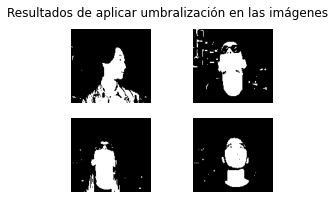

In [52]:
#Umbralización de las imagenes
threshold_images = []
for imagen in imagenes:
  T,sal = cv.threshold(imagen,100,255,cv.THRESH_BINARY)
  threshold_images.append(sal)


#Mostrando ejemplos de umbralización de las imágenes
fig = plt.figure(figsize=(4, 3))
fig.suptitle("Resultados de aplicar umbralización en las imágenes")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(threshold_images[100],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(threshold_images[150],cmap = "gray")
plt.axis('off')
  

fig.add_subplot(rows, columns, 3)
plt.imshow(threshold_images[200],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(threshold_images[250],cmap = "gray")
plt.axis('off')

plt.show()


### Obteniendo las etiquetas de las imágenes

Se obtienen de los nombres de las imágenes la respectiva información para saber si tiene o no tiene gafas.

In [53]:

labels = []
for image in files:
  aux = image.split("_")[3]
  labels.append(aux[:-4])

labels = np.array(labels)


Debido a que algunos clasificadores no reciben las clases o etiquetas en forma de texto, se binarizan quedando de la siguiente manera:  
0 ->  No tiene gafas  
1 -> Tiene gafas


In [54]:
#Binarizando las etiquetas
lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(labels)

## Clasificación

### Maquinas de soporte vectorial
Se utilizará como clasificador una máquina de soporte vectorial, esta técnica utiliza un hiperplano para separar las muestras de datos a 2 o más espacios lo más amplio posibles (depende de las clases). Las observaciones que queden más cercanas al hiperplano se les llama vectores soporte y son los que definen el clasificador obtenido.
Tiene un hiperparámetro C que controla la penalización de errores de clasificación, entre más cerca de cero, menos se penalizan.
Esta separación no solo se puede hacer de forma lineal, si no que se puede utilizar funciones Kernel (polinomico, radial,etc) para obtener un espacio de mayor dimensionalidad. Por lo que tienen un parámetro gamma que ayuda a controlar la flexibilidad del modelo. 



In [55]:
#Aplanamiento de imagenes
flatten_images = []
for image in threshold_images:
  flatten_images.append(image.flatten())


Entrenamiento del modelo SVM

Se dividen los datos en entrenamiento y validación.

In [56]:

X_train,X_test,y_train,y_test = train_test_split(flatten_images,
                                                 labels.ravel(),
                                                 train_size = 0.8,
                                                 random_state = 1234,
                                                 shuffle = True
                                                 )



Se utilizará validación cruzada para obtener los mejores parámetros de C, Gamma y kernel para el modelo basado en máquinas de vectores de soporte

In [58]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear','rbf','poly']}

svc = SVC(probability=True)
model = GridSearchCV(svc,param_grid)

In [59]:
#Buscamos los mejores parámetros
model.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Los mejores parámetros encontrados son:

In [96]:

print("C:",model.best_params_["C"])
print("Gamma:",model.best_params_["gamma"])
print("Kernel:",model.best_params_["kernel"])

C: 0.1
Gamma: 0.0001
Kernel: linear


#### Visualizando desempeño del modelo

In [97]:
pred = model.predict(X_test)
Classification_report_svm = classification_report(y_test,pred,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score = pd.DataFrame(Classification_report_svm).T
Dataframe_score.round(2)

,precision,recall,f1-score,support
No tiene gafas,0.93,0.96,0.94,52.00
Tiene gafas,0.97,0.95,0.96,73.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.95,0.95,0.95,125.00
weighted avg,0.95,0.95,0.95,125.00


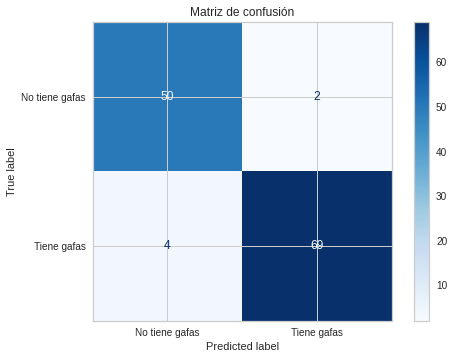

In [98]:
matriz_conf_svm = plot_confusion_matrix(model,X_test,y_test,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_svm.ax_.set_title("Matriz de confusión")
plt.show()

### K vecinos más cercanos (KNN)

Se desarrolla un segundo clasificador utilizando el método de los k vecinos más cercanos.

In [ ]:
#Se normalizan las imágenes
normalizadas = []
for image in threshold_images:
  normalizadas.append(image/255)

normalizadas = np.array(normalizadas)

#Se dividen los datos en entrenamiento, validación y estos a su vez en validación y test.

X_train, X_test, y_train, y_test = train_test_split(normalizadas,labels.flatten(),random_state = 42,test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,random_state = 42,test_size = 0.3)

num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_training = X_train.shape[0]

X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_test = np.reshape(X_test,(X_test.shape[0],-1))
X_val = np.reshape(X_val,(X_val.shape[0],-1))



Error mínimo:  0.13157894736842105 en K = 1


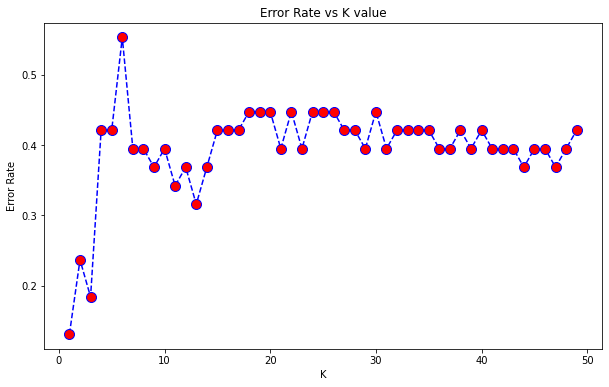

In [ ]:

#Buscando el mejor K

error_rate = []

for k in range(1,50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train,y_train)
  pred_i = neigh.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor = 'red',markersize = 10)
plt.title('Error Rate vs K value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Error mínimo: ",min(error_rate), "en K =",error_rate.index(min(error_rate))+1)

Max accuracy:  0.868421052631579 en K = 1


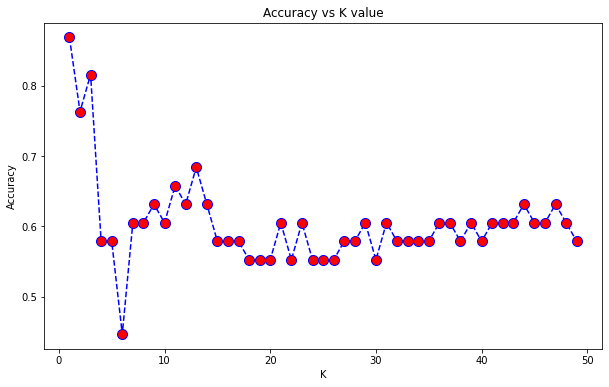

In [ ]:
acc = []

for k in range(1,50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train,y_train)
  pred_i = neigh.predict(X_test)
  acc.append(metrics.accuracy_score(y_test,pred_i))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),acc,color='blue',linestyle='dashed',marker='o',markerfacecolor = 'red',markersize = 10)
plt.title('Accuracy vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Max accuracy: ",max(acc), "en K =",acc.index(max(acc))+1)

Modelo con k=1

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)
print('Accuracy en entrenamiento: {:.2f}' 
      .format(knn_model.score(X_train,y_train)))
print('Accuracy en test: {:.2f}' .format(knn_model.score(X_test,y_test)))

Accuracy en entrenamiento: 1.00
Accuracy en test: 0.87


In [ ]:

pred = knn_model.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[13  1]
 [ 4 20]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.95      0.83      0.89        24

    accuracy                           0.87        38
   macro avg       0.86      0.88      0.86        38
weighted avg       0.88      0.87      0.87        38

